# Folders

In [ ]:
data_folder = '/data/'
prepr_data_folder = '/data/preprocessed/'

# Import Libs

In [ ]:
import kagglehub
import json
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
import requests
import time
from src.calculations_new import distribution_shift

# Functions

In [ ]:
def prepare_data(df, drop_cols, date_col, target_col):
    """Removes unnecessary columns, converts date and target, and fills missing values."""
    df = df.copy()

    df.drop(columns=drop_cols, inplace=True, errors="ignore")

    df[date_col] = pd.to_datetime(df[date_col])

    if df[target_col].dtype == 'bool':
        df[target_col] = df[target_col].astype(int)
    else:
        mapping = {True: 1, False: 0, 'True': 1, 'False': 0,
                   'true': 1, 'false': 0, 'Yes': 1, 'No': 0, 'Y': 1, 'N': 0}
        df[target_col] = df[target_col].replace(mapping).astype(int)

    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].fillna('None')

    return df


def split_by_time(df, date_col, target_col, train_frac=0.7, oos_frac=0.2):
    """Splits the data into train, OOS, and OOT sets based on time."""
    df = df.sort_values(date_col).reset_index(drop=True)
    n = len(df)
    i_train_end = int(n * train_frac)
    i_oos_end = i_train_end + int(n * oos_frac)

    train = df.iloc[:i_train_end].reset_index(drop=True)
    oos = df.iloc[i_train_end:i_oos_end].reset_index(drop=True)
    oot = df.iloc[i_oos_end:].reset_index(drop=True)
    return train, oos, oot


def get_cat_features(df):
    """Returns a list of categorical features."""
    cat_features = [c for c in df.columns if df[c].dtype == 'object'
                    or df[c].dtype.name == 'category'
                    or df[c].dtype == 'bool']
    for c in df.columns:
        if c not in cat_features and df[c].nunique() <= 10 and df[c].dtype.kind in 'iuf':
            cat_features.append(c)
    return list(dict.fromkeys(cat_features))


def train_catboost(X_train, y_train, X_val, y_val, cat_features, random_state=42):
    """Trains a CatBoostClassifier and returns the model."""
    pool_train = Pool(X_train, label=y_train, cat_features=cat_features)
    pool_val = Pool(X_val, label=y_val, cat_features=cat_features)

    model = CatBoostClassifier(

        verbose=100
    )

    model.fit(pool_train, eval_set=pool_val, use_best_model=True)
    return model


def evaluate_auc(model, X, y):
    """Calculates the AUC for the given data."""
    preds = model.predict_proba(X)[:, 1]
    return roc_auc_score(y, preds) if len(np.unique(y)) > 1 else float('nan')

In [ ]:
def plot_feature_importances(model, feature_names, top_n=20):
    """Plots the feature importance for CatBoost."""
    importances = model.feature_importances_
    idx_sorted = np.argsort(importances)[::-1][:top_n]
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(idx_sorted)), importances[idx_sorted], align="center")
    plt.yticks(range(len(idx_sorted)), [feature_names[i] for i in idx_sorted])
    plt.xlabel("Feature Importance")
    plt.title("CatBoost Feature Importances")
    plt.gca().invert_yaxis()
    plt.show()

In [ ]:
def add_macro_features_fixed(df, api_key="YOUR API KEY"):
    """
    Adds macroeconomic features to the dataset.
    """

    print("🔄 Starting to add macroeconomic indicators...")

    # Mapping of correct state-level unemployment series IDs
    STATE_UNEMPLOYMENT_SERIES = {
        'AL': 'ALUR',   'AK': 'AKUR',   'AZ': 'AZUR',   'AR': 'ARUR',   'CA': 'CAUR',
        'CO': 'COUR',   'CT': 'CTUR',   'DE': 'DEUR',   'FL': 'FLUR',   'GA': 'GAUR',
        'HI': 'HIUR',   'ID': 'IDUR',   'IL': 'ILUR',   'IN': 'INUR',   'IA': 'IAUR',
        'KS': 'KSUR',   'KY': 'KYUR',   'LA': 'LAUR',   'ME': 'MEUR',   'MD': 'MDUR',
        'MA': 'MAUR',   'MI': 'MIUR',   'MN': 'MNUR',   'MS': 'MSUR',   'MO': 'MOUR',
        'MT': 'MTUR',   'NE': 'NEUR',   'NV': 'NVUR',   'NH': 'NHUR',   'NJ': 'NJUR',
        'NM': 'NMUR',   'NY': 'NYUR',   'NC': 'NCUR',   'ND': 'NDUR',   'OH': 'OHUR',
        'OK': 'OKUR',   'OR': 'ORUR',   'PA': 'PAUR',   'RI': 'RIUR',   'SC': 'SCUR',
        'SD': 'SDUR',   'TN': 'TNUR',   'TX': 'TXUR',   'UT': 'UTUR',   'VT': 'VTUR',
        'VA': 'VAUR',   'WA': 'WAUR',   'WV': 'WVUR',   'WI': 'WIUR',   'WY': 'WYUR',
        'DC': 'DCUR'
    }

    result_df = df.copy()
    result_df['unemployment_rate'] = np.nan
    result_df['federal_funds_rate'] = np.nan

    date_col = 'year_month'
    if 'issue_d' in df.columns:
        date_col = 'issue_d'
    elif 'year_month' not in df.columns:
        raise ValueError("The data must contain a 'year_month' or 'issue_d' column.")

    result_df['date'] = pd.to_datetime(result_df[date_col], errors='coerce')

    groups = result_df.groupby(['addr_state', pd.Grouper(key='date', freq='M')])
    processed_ff_dates = set()

    for (state, date), group_idx in groups.groups.items():
        if pd.isna(state) or pd.isna(date):
            continue

        state_upper = state.upper()
        print(f"→ Fetching data for {state_upper} for {date.strftime('%Y-%m')}")

        if state_upper in STATE_UNEMPLOYMENT_SERIES:
            series_id = STATE_UNEMPLOYMENT_SERIES[state_upper]
            unemployment_rate = _get_fred_series(api_key, series_id, date)
            result_df.loc[group_idx, 'unemployment_rate'] = unemployment_rate
        else:
            print(f"⚠️ No data available for state {state_upper}")

        date_key = date.strftime('%Y-%m')
        if date_key not in processed_ff_dates:
            ff_series_id = "DFF"
            federal_rate = _get_fred_series(api_key, ff_series_id, date)

            same_month_mask = result_df['date'].dt.to_period('M') == date.to_period('M')
            result_df.loc[same_month_mask, 'federal_funds_rate'] = federal_rate
            processed_ff_dates.add(date_key)

        time.sleep(0.5)

    print(f"✅ Records processed: {len(result_df)}")
    print(f"📊 Missing unemployment data: {result_df['unemployment_rate'].isna().sum()}")
    print(f"📊 Missing federal funds rate data: {result_df['federal_funds_rate'].isna().sum()}")


    return result_df.drop(columns=['date'])

def _get_fred_series(api_key, series_id, target_date, max_retries=2):
    """
    Function to fetch data with flexible date search.
    """

    date_start = target_date.replace(day=1)
    date_end = (target_date.replace(day=1) + pd.DateOffset(months=1) - pd.Timedelta(days=1))

    url = (
        f"https://api.stlouisfed.org/fred/series/observations?"
        f"series_id={series_id}&"
        f"observation_start={date_start.strftime('%Y-%m-%d')}&"
        f"observation_end={date_end.strftime('%Y-%m-%d')}&"
        f"api_key={api_key}&"
        f"file_type=json"
    )

    for attempt in range(max_retries):
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            data = response.json()

            if 'observations' in data and len(data['observations']) > 0:
                valid_obs = [obs for obs in data['observations']
                            if obs['value'] not in ('.', '', 'M')]

                if valid_obs:
                    return float(valid_obs[-1]['value'])

        except Exception as e:
            if attempt == max_retries - 1:
                print(f"⚠️ Failed to retrieve {series_id} for {target_date.strftime('%Y-%m')}: {str(e)[:50]}")

    return np.nan

# Load Data

In [ ]:
path = kagglehub.dataset_download("wordsforthewise/lending-club")

print("Path to dataset files:", path)

100%|██████████| 1.26G/1.26G [00:43<00:00, 30.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/wordsforthewise/lending-club/versions/3


In [ ]:
data = pd.read_csv(path + '/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv')

data.shape

/tmp/ipython-input-2203210106.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path + '/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv')


(2260701, 151)

# Exploratory Analysis

/tmp/ipython-input-2662631132.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['issue_d'] = pd.to_datetime(data['issue_d'], errors='coerce')


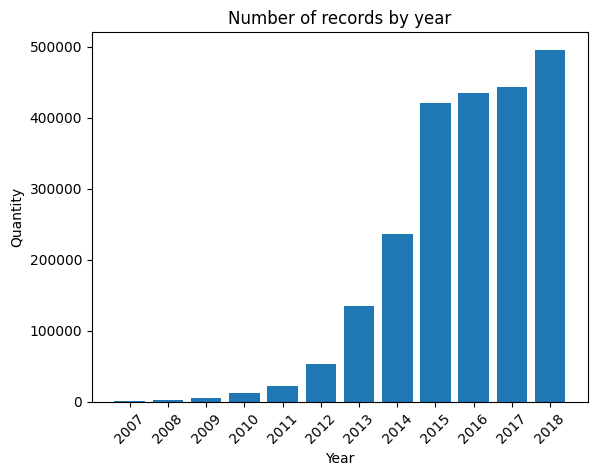

In [ ]:
data['issue_d'] = pd.to_datetime(data['issue_d'], errors='coerce')

year_counts = data['issue_d'].dt.year.value_counts().sort_index()

plt.bar(year_counts.index, year_counts.values)
plt.xlabel('Year')
plt.ylabel('Quantity')
plt.title('Number of records by year')
plt.xticks(year_counts.index, rotation=45)
plt.show()

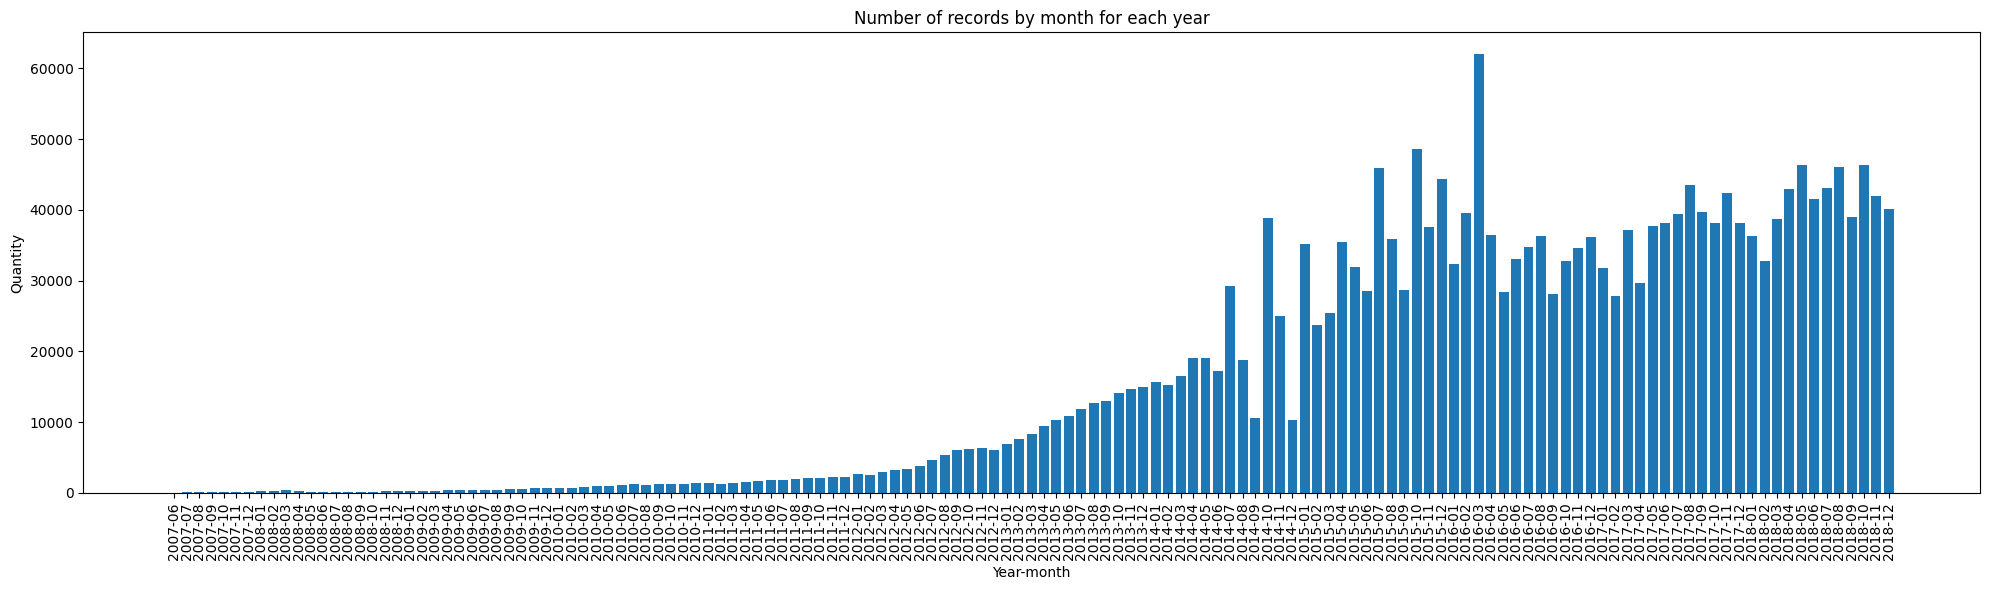

In [ ]:
data['issue_d'] = pd.to_datetime(data['issue_d'], errors='coerce')

data['year_month'] = data['issue_d'].dt.to_period('M')

month_counts = data['year_month'].value_counts().sort_index()

labels = month_counts.index.astype(str)

plt.figure(figsize=(20,6))
plt.bar(labels, month_counts.values)
plt.xlabel('Year-month')
plt.ylabel('Quantity')
plt.title('Number of records by month for each year')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Data Cleansing

Part of the data cleaning process was taken from the notebook:

https://www.kaggle.com/code/emmaruyiyang/lending-club-loan-default-prediction-eda

In [ ]:
data = data[:-2]

In [ ]:
complete_df = data.copy()

bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period",
            "Late (16-30 days)", "Late (31-120 days)"]
complete_df['loan_condition_int'] = complete_df['loan_status'].apply(lambda status: 1 if status in bad_loan else 0).astype(int)
complete_df['loan_condition'] = np.where(complete_df['loan_condition_int'] == 0, 'Good Loan', 'Bad Loan')

#emp_length
emp_length_mapping = {
    '10+ years': 10,
    '9 years': 9,
    '8 years': 8,
    '7 years': 7,
    '6 years': 6,
    '5 years': 5,
    '4 years': 4,
    '3 years': 3,
    '2 years': 2,
    '1 year': 1,
    '< 1 year': 0.5,
    'n/a': 0
}
complete_df['emp_length_int'] = complete_df['emp_length'].map(emp_length_mapping)
complete_df.head().transpose()

state_to_region = {
    'CA': 'West', 'OR': 'West', 'UT': 'West', 'WA': 'West', 'CO': 'West',
    'NV': 'West', 'AK': 'West', 'MT': 'West', 'HI': 'West', 'WY': 'West', 'ID': 'West',
    'AZ': 'SouthWest', 'TX': 'SouthWest', 'NM': 'SouthWest', 'OK': 'SouthWest',
    'GA': 'SouthEast', 'NC': 'SouthEast', 'VA': 'SouthEast', 'FL': 'SouthEast', 'KY': 'SouthEast',
    'SC': 'SouthEast', 'LA': 'SouthEast', 'AL': 'SouthEast', 'WV': 'SouthEast', 'DC': 'SouthEast',
    'AR': 'SouthEast', 'DE': 'SouthEast', 'MS': 'SouthEast', 'TN': 'SouthEast',
    'IL': 'MidWest', 'MO': 'MidWest', 'MN': 'MidWest', 'OH': 'MidWest', 'WI': 'MidWest',
    'KS': 'MidWest', 'MI': 'MidWest', 'SD': 'MidWest', 'IA': 'MidWest', 'NE': 'MidWest',
    'IN': 'MidWest', 'ND': 'MidWest',
    'CT': 'NorthEast', 'NY': 'NorthEast', 'PA': 'NorthEast', 'NJ': 'NorthEast', 'RI': 'NorthEast',
    'MA': 'NorthEast', 'MD': 'NorthEast', 'VT': 'NorthEast', 'NH': 'NorthEast', 'ME': 'NorthEast'
}
complete_df['region'] = complete_df['addr_state'].map(state_to_region)
complete_df.head().transpose()

,0,1,2,3,4
id,68407277,68355089,68341763,66310712,68476807
member_id,NaN,NaN,NaN,NaN,NaN
loan_amnt,3600.0,24700.0,20000.0,35000.0,10400.0
funded_amnt,3600.0,24700.0,20000.0,35000.0,10400.0
funded_amnt_inv,3600.0,24700.0,20000.0,35000.0,10400.0
...,...,...,...,...,...
year_month,2015-12,2015-12,2015-12,2015-12,2015-12
loan_condition_int,0,0,0,0,0
loan_condition,Good Loan,Good Loan,Good Loan,Good Loan,Good Loan
emp_length_int,10.0,10.0,10.0,10.0,3.0


In [ ]:
complete_df['loan_condition_int'].value_counts()

,count
loan_condition_int,
0,1957087
1,303612


In [ ]:
drop_df = complete_df.copy()
drop_df = complete_df[~complete_df['loan_status'].isin(['Current', 'Issued',
                                #  'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)',
                                # 'Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off'
                                                           ])]

In [ ]:
drop_df.dropna(subset='loan_condition_int', inplace=True)

In [ ]:
drop_df = drop_df.dropna(axis=1, thresh=int(0.20*len(drop_df)))

In [ ]:
drop_df.drop(['emp_length'], axis=1, inplace=True)

drop_df.drop(['id','emp_title','url','title','zip_code'], axis=1, inplace=True)

In [ ]:
drop_df.shape

(1382382, 110)

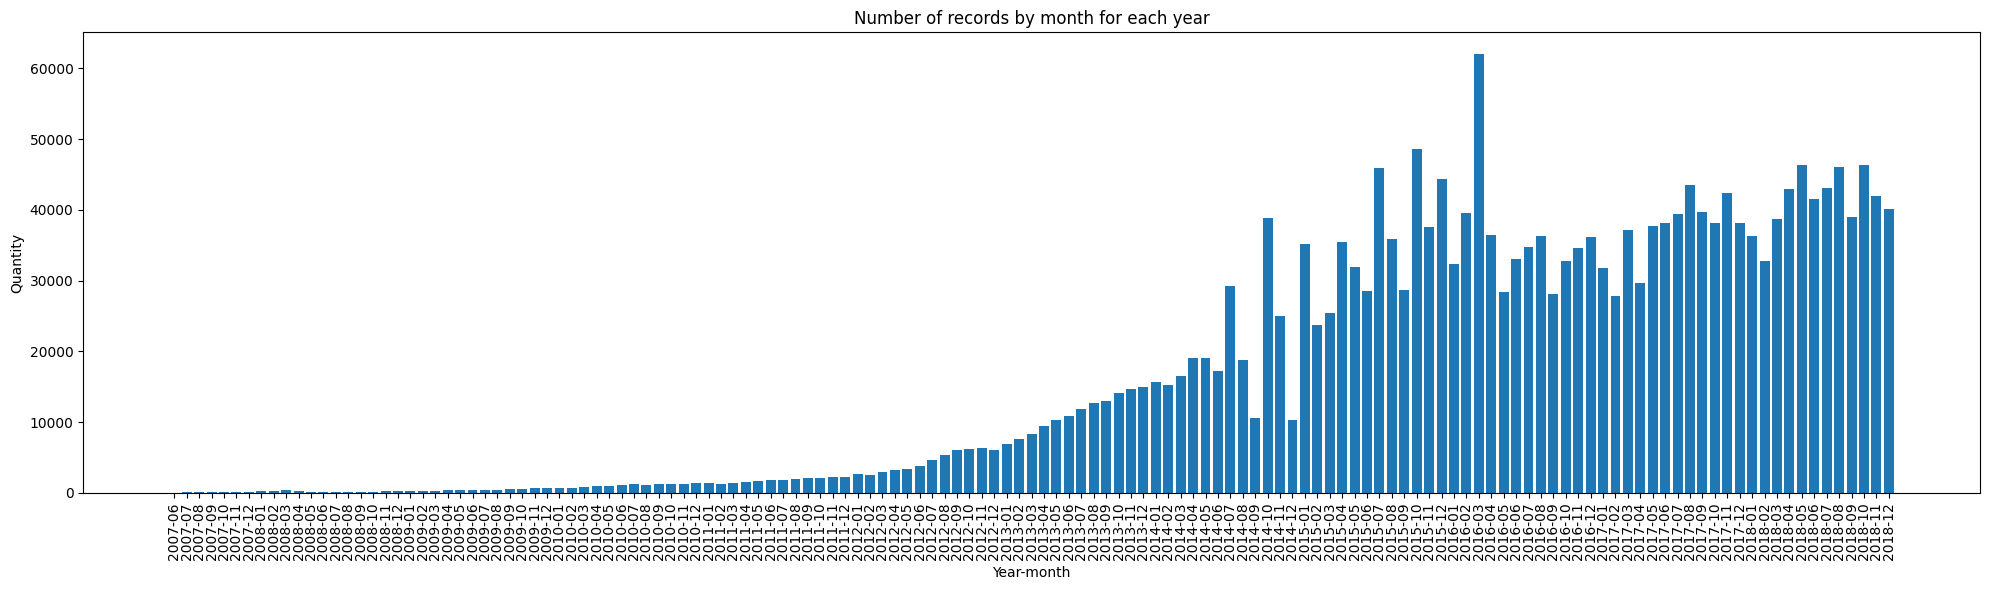

In [ ]:
data['issue_d'] = pd.to_datetime(data['issue_d'], errors='coerce')

data['year_month'] = data['issue_d'].dt.to_period('M')

month_counts = data['year_month'].value_counts().sort_index()

labels = month_counts.index.astype(str)

plt.figure(figsize=(20,6))
plt.bar(labels, month_counts.values)
plt.xlabel('Year-month')
plt.ylabel('Quantity')
plt.title('Number of records by month for each year')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
nan_counts = drop_df.isna().sum()

nan_ratio = nan_counts / len(drop_df)

nan_summary = pd.DataFrame({'nan_count': nan_counts, 'nan_ratio': nan_ratio}).sort_values(by='nan_ratio', ascending=False)

print(nan_summary)

                                nan_count  nan_ratio
mths_since_recent_bc_dlq          1054549   0.762849
mths_since_last_major_derog       1018207   0.736560
mths_since_recent_revol_delinq     919977   0.665501
il_util                            890427   0.644125
mths_since_rcnt_il                 828537   0.599355
...                                   ...        ...
disbursement_method                    31   0.000022
year_month                             31   0.000022
region                                 31   0.000022
loan_condition                          0   0.000000
loan_condition_int                      0   0.000000

[110 rows x 2 columns]


In [ ]:
cat_cols = drop_df.select_dtypes(include=['object', 'category']).columns

nan_in_cat = drop_df[cat_cols].isna().sum()

nan_in_cat = nan_in_cat[nan_in_cat > 0]

print(nan_in_cat)

term                      31
grade                     31
sub_grade                 31
home_ownership            31
verification_status       31
loan_status               31
pymnt_plan                31
purpose                   31
addr_state                31
earliest_cr_line          60
initial_list_status       31
last_pymnt_d            2458
last_credit_pull_d        88
application_type          31
hardship_flag             31
disbursement_method       31
debt_settlement_flag      31
region                    31
dtype: int64


In [ ]:
fillna_df = drop_df.copy()

for column in ["last_pymnt_d", "last_credit_pull_d"]:
    fillna_df[column] = fillna_df.groupby("region")[column].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else pd.NaT)
)

fillna_df["pub_rec"] = fillna_df.groupby("region")["pub_rec"].transform(lambda x: x.fillna(x.median()))
fillna_df["total_acc"] = fillna_df.groupby("region")["total_acc"].transform(lambda x: x.fillna(x.median()))

fillna_df["emp_length_int"] = fillna_df.groupby("region")["emp_length_int"].transform(lambda x: x.fillna(x.median()))

fillna_df["annual_inc"] = fillna_df.groupby("region")["annual_inc"].transform(lambda x: x.fillna(x.mean()))
fillna_df["delinq_2yrs"] = fillna_df.groupby("region")["delinq_2yrs"].transform(lambda x: x.fillna(x.mean()))

In [ ]:
cat_cols = fillna_df.select_dtypes(include=['object', 'category']).columns

nan_in_cat = fillna_df[cat_cols].isna().sum()

nan_in_cat = nan_in_cat[nan_in_cat > 0]

print(nan_in_cat)

term                    31
grade                   31
sub_grade               31
home_ownership          31
verification_status     31
loan_status             31
pymnt_plan              31
purpose                 31
addr_state              31
earliest_cr_line        60
initial_list_status     31
last_pymnt_d            31
last_credit_pull_d      31
application_type        31
hardship_flag           31
disbursement_method     31
debt_settlement_flag    31
region                  31
dtype: int64


In [ ]:
drop_df = fillna_df.copy()

In [ ]:
drop_df.dropna(subset=list(nan_in_cat.reset_index()['index'].values), inplace=True)
drop_df.shape

(1382322, 110)

In [ ]:
cat_cols = drop_df.select_dtypes(include=['object', 'category']).columns

nan_in_cat = drop_df[cat_cols].isna().sum()

nan_in_cat = nan_in_cat[nan_in_cat > 0]

print(nan_in_cat)

Series([], dtype: int64)


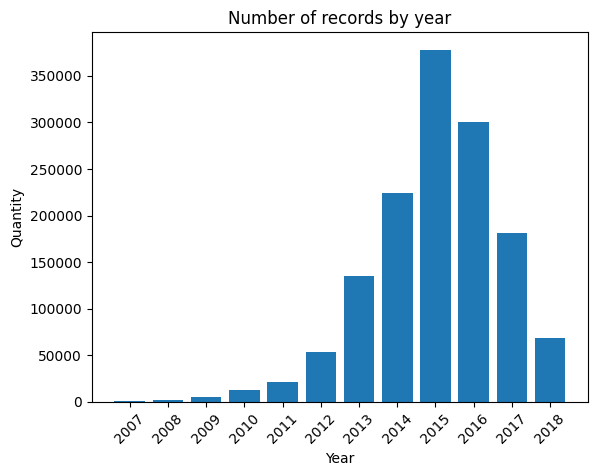

In [ ]:
drop_df['issue_d'] = pd.to_datetime(drop_df['issue_d'], errors='coerce')

year_counts = drop_df['issue_d'].dt.year.value_counts().sort_index()

plt.bar(year_counts.index, year_counts.values)
plt.xlabel('Year')
plt.ylabel('Quantity')
plt.title('Number of records by year')
plt.xticks(year_counts.index, rotation=45)
plt.show()

# Add Macrodata

In [ ]:
enriched_data = add_macro_features_fixed(drop_df)

In [ ]:
enriched_data

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,...,hardship_flag,disbursement_method,debt_settlement_flag,year_month,loan_condition_int,loan_condition,emp_length_int,region,unemployment_rate,federal_funds_rate
0,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,MORTGAGE,55000.0,...,N,Cash,N,2015-12,0,Good Loan,10.0,NorthEast,4.5,0.20
1,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,MORTGAGE,65000.0,...,N,Cash,N,2015-12,0,Good Loan,10.0,MidWest,2.8,0.20
2,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,MORTGAGE,63000.0,...,N,Cash,N,2015-12,0,Good Loan,10.0,MidWest,5.0,0.20
4,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,MORTGAGE,104433.0,...,N,Cash,N,2015-12,0,Good Loan,3.0,NorthEast,4.6,0.20
5,11950.0,11950.0,11950.0,36 months,13.44,405.18,C,C3,RENT,34000.0,...,N,Cash,N,2015-12,0,Good Loan,4.0,SouthEast,4.5,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260686,23800.0,23800.0,23800.0,60 months,14.49,559.85,C,C4,MORTGAGE,119000.0,...,N,Cash,N,2016-10,0,Good Loan,10.0,MidWest,4.5,0.31
2260688,18000.0,18000.0,18000.0,60 months,9.49,377.95,B,B2,OWN,130000.0,...,N,Cash,N,2016-10,0,Good Loan,5.0,SouthWest,3.8,0.31
2260690,29400.0,29400.0,29400.0,60 months,13.99,683.94,C,C3,MORTGAGE,180792.0,...,N,Cash,N,2016-10,0,Good Loan,9.0,West,4.3,0.31
2260691,32000.0,32000.0,32000.0,60 months,14.49,752.74,C,C4,MORTGAGE,157000.0,...,N,Cash,N,2016-10,1,Bad Loan,3.0,SouthWest,5.0,0.31


In [ ]:
data = enriched_data.sample(100000, random_state=42) # drop_df

In [ ]:
cat_cols = data.select_dtypes(include=['object', 'category']).columns

nan_in_cat = data[cat_cols].isna().sum()

nan_in_cat = nan_in_cat[nan_in_cat > 0]

print(nan_in_cat)

Series([], dtype: int64)


In [ ]:
cat_features = get_cat_features(data)

nan_in_cat = data[cat_features].isna().sum()

nan_in_cat = nan_in_cat[nan_in_cat > 0]

print(nan_in_cat)

collections_12_mths_ex_med       11
open_il_12m                   58905
chargeoff_within_12_mths         11
num_tl_120dpd_2m               8781
num_tl_30dpd                   5133
pub_rec_bankruptcies            100
dtype: int64


In [ ]:
nan_in_cat.reset_index()['index'].values

array(['collections_12_mths_ex_med', 'open_il_12m',
       'chargeoff_within_12_mths', 'num_tl_120dpd_2m', 'num_tl_30dpd',
       'pub_rec_bankruptcies'], dtype=object)

In [ ]:
data['num_tl_30dpd'].value_counts()

,count
num_tl_30dpd,
0.0,94590
1.0,270
2.0,7


In [ ]:
data['issue_d'] = pd.to_datetime(data['issue_d'])

In [ ]:
data['loan_condition_int'].value_counts()

,count
loan_condition_int,
0,78126
1,21874


In [ ]:
data['year_month'] = pd.to_datetime(data['issue_d']).dt.to_period('M')

# Modeling with all features

In [ ]:
drop_cols = ['debt_settlement_flag',
    'collections_12_mths_ex_med',
             'chargeoff_within_12_mths',
             'num_tl_120dpd_2m',
             'num_tl_30dpd',
             'pub_rec_bankruptcies',
             'loan_condition',
             'loan_status',
             'collection_recovery_fee',
              'last_pymnt_amnt',
              'out_prncp',
              'out_prncp_inv',
              'recoveries',
              'total_pymnt',
              'total_pymnt_inv',
              'total_rec_int',
              'total_rec_late_fee',
              'total_rec_prncp',
             'policy_code', 'year_month',
             'last_credit_pull_d',
              'last_fico_range_high',
              'last_fico_range_low',
             'last_pymnt_d']
drop_cols = []

date_col = 'issue_d'
target_col = 'loan_condition_int'

df_prep = prepare_data(data, drop_cols, date_col, target_col)

train_df, oos_df, oot_df = split_by_time(df_prep, date_col, target_col)

X_train = train_df.drop(columns=[target_col, date_col])
y_train = train_df[target_col]

X_oos = oos_df.drop(columns=[target_col, date_col])
y_oos = oos_df[target_col]

X_oot = oot_df.drop(columns=[target_col, date_col])
y_oot = oot_df[target_col]

cat_features = get_cat_features(X_train)

for col in cat_features:
    X_train[col] = X_train[col].astype(str)
    X_oot[col] = X_oot[col].astype(str)
    X_oos[col] = X_oos[col].astype(str)

model = train_catboost(X_train, y_train, X_oos, y_oos, cat_features)

auc_train = evaluate_auc(model, X_train, y_train)
auc_oos = evaluate_auc(model, X_oos, y_oos)
auc_oot = evaluate_auc(model, X_oot, y_oot)

print(f"AUC train: {auc_train:.4f}")
print(f"AUC oos:   {auc_oos:.4f}")
print(f"AUC oot:   {auc_oot:.4f}")

In [ ]:
plot_feature_importances(model, X_train.columns, top_n=15)

In [ ]:
feature_importances = model.get_feature_importance()
feature_names = model.feature_names_

feat_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

top20_features = feat_df.head(20)
print(top20_features)

In [ ]:
top20_list = feat_df.head(20)['feature'].tolist()
print(top20_list)

# Modeling with top 20 features

In [ ]:
data = data[top20_list+['issue_d', 'loan_condition_int']]

In [ ]:
drop_cols = ['debt_settlement_flag',
    'collections_12_mths_ex_med',
             'chargeoff_within_12_mths',
             'num_tl_120dpd_2m',
             'num_tl_30dpd',
             'pub_rec_bankruptcies',
             'loan_condition',
             'loan_status',
             'collection_recovery_fee',
              'last_pymnt_amnt',
              'out_prncp',
              'out_prncp_inv',
              'recoveries',
              'total_pymnt',
              'total_pymnt_inv',
              'total_rec_int',
              'total_rec_late_fee',
              'total_rec_prncp',
             'policy_code', 'year_month',
             'last_credit_pull_d',
              'last_fico_range_high',
              'last_fico_range_low',
             'last_pymnt_d']
drop_cols = []

date_col = 'issue_d'
target_col = 'loan_condition_int'

df_prep = prepare_data(data, drop_cols, date_col, target_col)

train_df, oos_df, oot_df = split_by_time(df_prep, date_col, target_col)

X_train = train_df.drop(columns=[target_col, date_col])
y_train = train_df[target_col]

X_oos = oos_df.drop(columns=[target_col, date_col])
y_oos = oos_df[target_col]

X_oot = oot_df.drop(columns=[target_col, date_col])
y_oot = oot_df[target_col]

cat_features = get_cat_features(X_train)

for col in cat_features:
    X_train[col] = X_train[col].astype(str)
    X_oot[col] = X_oot[col].astype(str)
    X_oos[col] = X_oos[col].astype(str)

model = train_catboost(X_train, y_train, X_oos, y_oos, cat_features)

auc_train = evaluate_auc(model, X_train, y_train)
auc_oos = evaluate_auc(model, X_oos, y_oos)
auc_oot = evaluate_auc(model, X_oot, y_oot)

print(f"AUC train: {auc_train:.4f}")
print(f"AUC oos:   {auc_oos:.4f}")
print(f"AUC oot:   {auc_oot:.4f}")

Learning rate set to 0.0905
0:	learn: 0.6446437	test: 0.6568102	best: 0.6568102 (0)	total: 34.1ms	remaining: 34.1s
100:	learn: 0.4309216	test: 0.5614868	best: 0.5518586 (13)	total: 2.58s	remaining: 22.9s
200:	learn: 0.4218087	test: 0.5607480	best: 0.5518586 (13)	total: 5.2s	remaining: 20.7s
300:	learn: 0.4138973	test: 0.5609276	best: 0.5518586 (13)	total: 8.14s	remaining: 18.9s
400:	learn: 0.4066236	test: 0.5618665	best: 0.5518586 (13)	total: 10.8s	remaining: 16.1s
500:	learn: 0.3999558	test: 0.5628538	best: 0.5518586 (13)	total: 13.4s	remaining: 13.4s
600:	learn: 0.3937926	test: 0.5640649	best: 0.5518586 (13)	total: 16s	remaining: 10.6s
700:	learn: 0.3877391	test: 0.5656916	best: 0.5518586 (13)	total: 18.9s	remaining: 8.05s
800:	learn: 0.3816262	test: 0.5665982	best: 0.5518586 (13)	total: 21.7s	remaining: 5.39s
900:	learn: 0.3758427	test: 0.5674336	best: 0.5518586 (13)	total: 24.4s	remaining: 2.68s
999:	learn: 0.3704867	test: 0.5687716	best: 0.5518586 (13)	total: 27.1s	remaining: 0us


In [ ]:
data['last_fico_range_high'].value_counts()

,count
last_fico_range_high,
699.0,3185
694.0,3175
704.0,3173
709.0,3127
714.0,3071
...,...
834.0,151
839.0,88
844.0,35


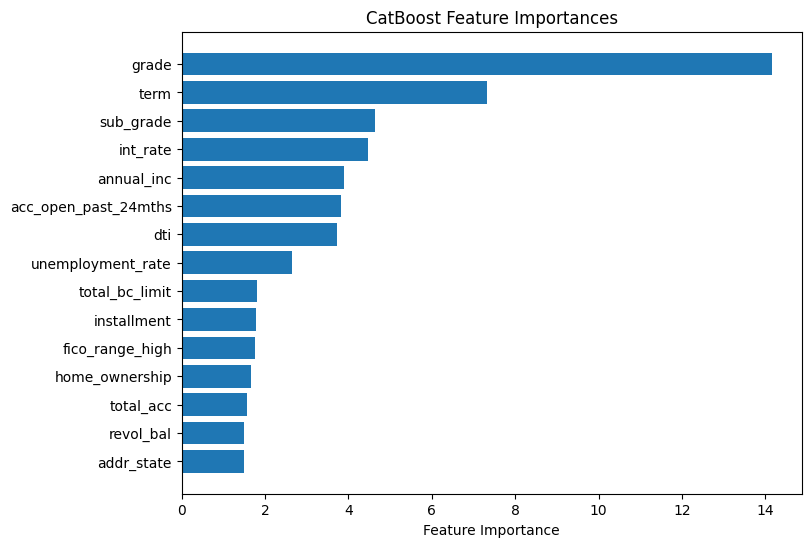

In [ ]:
plot_feature_importances(model, X_train.columns, top_n=15)

# Shock Split Data

In [ ]:
# enriched_data.to_parquet(prepr_data_folder+'lending_club.parquet', index=False)

In [ ]:
enriched_data.shape

(1382321, 112)

In [ ]:
shock_data = enriched_data.query('issue_d >= "2018-03-22"')
base_data = enriched_data.query('issue_d < "2018-03-22"')

shock_data.shape, base_data.shape

((42322, 112), (1339999, 112))

In [ ]:
distribution_shift(base_data, shock_data)

np.float64(0.09874177146499291)

In [ ]:
base_train_data = base_data[:-42322].copy()
base_test_data = base_data[-42322:].copy()

base_train_data.reset_index(drop=True, inplace = True)
base_test_data.reset_index(drop=True, inplace = True)

base_train_data.shape, base_test_data.shape

((1297677, 112), (42322, 112))

# Save Data

In [ ]:
base_train_data.to_parquet(prepr_data_folder+'base_train_data.parquet', index=False)
base_test_data.to_parquet(prepr_data_folder+'base_test_data.parquet', index=False)

In [ ]:
shock_data.to_parquet(prepr_data_folder+'shock_data.parquet', index=False)

In [ ]:
sample_base_train_data = base_train_data.sample(50000)
sample_base_train_data.shape

(50000, 112)

In [ ]:
sample_base_train_data.to_parquet(prepr_data_folder+'sample_base_train_data.parquet', index=False)